# Compilation Stages


## Custom compilation stage

The generic lifecycle of a Pulla job is a one-way multi-step transformation. The states are as follow:

1. Quantum Circuit in a specific format (e.g. Qiskit, Cirq)
2. Equivalent Quantum Circuit in an IQM Pulse format (list of CircuitOperations)
3. IQM Pulse nested Timebox representation
4. IQM Pulse Schedule representation
5. Measurement results

You don't have to start with a circuit, you can define quantum operations directly (roughly starting from state 2), or define pulse shapes directly (roughly starting from state 3 or 4). The compilation which produces states 3 and 4 is itself multi-step: it consists of multiple stages, and each stage of one or more passes. 

Let's go over the generic use case, starting from creating a Qiskit circuit to work on:

In [1]:
import os
from math import pi
from pprint import pprint
from qiskit import QuantumCircuit, visualization
from qiskit.compiler import transpile
from iqm.qiskit_iqm import IQMProvider
from iqm.qiskit_iqm.iqm_transpilation import optimize_single_qubit_gates
from iqm.pulla.pulla import Pulla
from iqm.pulla.utils_qiskit import sweep_job_to_qiskit

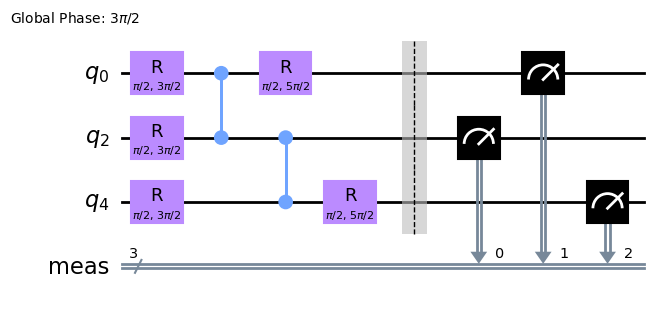

In [2]:
iqm_server_url = os.environ['PULLA_IQM_SERVER_URL']  # or set the URL directly here
os.environ["IQM_TOKEN"] = os.environ.get("IQM_TOKEN")  # or set the token directly here

provider = IQMProvider(iqm_server_url)
backend = provider.get_backend()

qc = QuantumCircuit(3, 3)
qc.h(0)
qc.cx(0, 1)
qc.cx(0, 2)
qc.measure_all()

# Transpile, route and optimize the circuit
qc_transpiled = transpile(qc, backend=backend, layout_method='sabre', optimization_level=3)
qc_optimized = optimize_single_qubit_gates(qc_transpiled)

# Print the circuit
qc_optimized.draw(output='mpl', style="clifford", idle_wires=False)

Pulla has utility functions which accept circuits in different formats (Qiskit, Cirq, IQM JSON) and convert them into Pulla/IQM Pulse format, which is a list of `CircuitOperation` objects. Let's do that. Note that none of the operations have an implementation specified (`implementation=None`).

The Qiskit conversion utility also gives us a standard compiler with the same calibration set as the one used by `backend`, in this case the current default one.

In [3]:
from iqm.pulla.utils_qiskit import qiskit_to_pulla

p = Pulla(iqm_server_url)
circuits, compiler = qiskit_to_pulla(p, backend, qc_optimized)

pprint(circuits[0])

[11-26 14:02:08;W] station-control-client version '1.23' is newer minor version than '1.18' used by the station control server, some new client features might not be supported.


Circuit(name='circuit-166',
        instructions=(CircuitOperation(name='prx',
                                       locus=('0',),
                                       args={'angle_t': 0.25, 'phase_t': 0.75},
                                       implementation=None),
                      CircuitOperation(name='prx',
                                       locus=('2',),
                                       args={'angle_t': 0.25, 'phase_t': 0.75},
                                       implementation=None),
                      CircuitOperation(name='cz',
                                       locus=('2', '0'),
                                       args={},
                                       implementation=None),
                      CircuitOperation(name='prx',
                                       locus=('0',),
                                       args={'angle_t': 0.25, 'phase_t': 1.25},
                                       implementation=None),
                     

In order to understand how the compilation stages work, let's remove the standard stages from the compiler:

In [4]:
compiler.stages = []

You can check the readiness of the compiler by calling `compiler.ready()`. Right now it would return `False` due to empty stages list.

The compiler flow consists of one or more stages, and each stage consists of one or more passes. When the compiler is initialized created by Pulla, it is pre-populated with standard stages. 

You can define your own stages, with your own passes, grouping them in some meaningful way. Each pass is a function which accepts two arguments: data and context. Data is an iterable of objects of an applicable data type, and context is a dictionary of any additional information. Each pass can transform the data and modify the context, and must return both data and context. This convention allows the compiler to pipe arbitrary amount of passes.

A stage is just an ordered collection of passes. The compiler has methods `run_stage()` and `run_pass()` allowing you to run particular stages or passes. The `compile()` method is just calling `run_stage()` in correct order and passes its initial context to the first pass of the first stage. 

Let's write a simple compilation stage to illustrate the concept:

In [5]:
from iqm.cpc.compiler.compiler import CompilationStage

my_stage = CompilationStage(name="my_stage")

Now let's write two simple passes for that stage. For the first: perhaps we want to add a leading barrier to each circuit.
`add_leading_barrier` below determines the locations of qubits used in the circuit and adds a barrier on those qubits as the first instruction.

In [6]:
from iqm.pulse import CircuitOperation


def add_leading_barrier(circuits, context):
    """Add leading barrier on all used qubits."""
    for circuit in circuits:
        loci = [inst.locus for inst in circuit.instructions]
        loci = [i for sub in loci for i in sub]
        loci = tuple(set(loci))
        new_barrier = CircuitOperation(name='barrier', locus=loci, args={}, implementation=None)
        circuit.instructions = (new_barrier,) + circuit.instructions
    return circuits, context

Note that the function takes data and context and returns data and context. It happens to neither use nor modify the context, but it should still provide it down to the next passes.

Ok, let's define another pass: this one would increase the phase of each `prx` operation by `0.5 * pi`. This may or may
not make practical sense, but bear with us for the purposes of illustration:

In [7]:
def increase_phase(circuits, context):
    """Add 0.5*pi to phase of each prx gate."""
    for circuit in circuits:
        for instruction in circuit.instructions:
            if instruction.name == 'prx':
                print(instruction.args)
                instruction.args['phase'] += 0.5 * pi
    return circuits, context

Now let's add those two passes to our stage, then replace the empty `stages` property of the compiler with a list consisting of our single stage, and then call `show_stages()`:

In [8]:
my_stage.add_passes(add_leading_barrier, increase_phase)
compiler.stages = [my_stage]

compiler.show_stages(full=True)

Stage 0: my_stage
    0: add_leading_barrier
        Add leading barrier on all used qubits.
    1: increase_phase
        Add 0.25 to phase_t of each prx gate.




The boolean flag `full` of `show_stages()` is optional; when `True`, the doc strings of each pass are printed on the screen. 

Now that the compiler is ready and we can run `compile`. The compiler always operates on batches of circuits, so you need to provide an iterable; in our case, it's a list with a single circuit. 

In [9]:
data, context = compiler.compile(circuits)

{'angle_t': 0.25, 'phase_t': 0.75}
{'angle_t': 0.25, 'phase_t': 0.75}
{'angle_t': 0.25, 'phase_t': 1.25}
{'angle_t': 0.25, 'phase_t': 0.75}
{'angle_t': 0.25, 'phase_t': 1.25}


Note that it did not really compile the circuits into pulse schedules, because the only passes we've defined only modify the circuits, but don't perform the conversion to pulse schedules. The compilation to pulse schedules usually consists of converting circuits to `TimeBox`es, then resolving `TimeBox`es into a single `TimeBox`, then resolving it into a `Schedule`, and finally converting a `Schedule` into a final `Schedule` ready to be submitted to the server. 

There might be cases when your compilation stages need additional data. You can provide such data as a custom context dictionary. Get the initial compiler context and modify it, then pass it when calling `compile`.

In [10]:
context = compiler.compiler_context()
context["some_extra_data"] = [1, 2, 3]
data, context = compiler.compile(circuits, context)

{'angle_t': 0.25, 'phase_t': 1.0}
{'angle_t': 0.25, 'phase_t': 1.0}
{'angle_t': 0.25, 'phase_t': 1.5}
{'angle_t': 0.25, 'phase_t': 1.0}
{'angle_t': 0.25, 'phase_t': 1.5}


## Standard stages

As mentioned earlier, Pulla comes with a pre-defined "standard" set of stages which you can use and, if needed, modify. These standard stages are used by IQM Server if you were to submit a circuit to IQM Server (without using Pulla). Thus, if you use the same version of the Pulla library that the remote IQM Server uses, you will be able to produce and inspect the same pulse schedules that IQM Server would (assuming you use the same calibration set).

Let's replace our current single stage with standard stages, and view them:

In [11]:
from iqm.cpc.compiler.standard_stages import get_standard_stages

compiler.stages = get_standard_stages()
compiler.show_stages()

Stage 0: circuit
    0: validate_circuits_move_gate
    1: map_old_operations
    2: map_implementations_for_loci
    3: derive_readout_mappings


Stage 1: circuit_resolution
    0: resolve_circuits


Stage 2: timebox
    0: multiplex_readout
    1: prepend_heralding
    2: prepend_reset


Stage 3: timebox_resolution
    0: resolve_timeboxes


Stage 4: dynamical_decoupling
    0: apply_dd_strategy


Stage 5: schedule
    0: apply_move_gate_phase_corrections
    1: clean_schedule


Stage 6: schedule_resolution
    0: build_playlist




There are 7 standard stages:

1. circuit-level: takes care of validating the circuit, renaming some deprecated names, gathering
information for the next stages
2. circuit resolution: converts circuits to `TimeBox`es
3. timebox-level: optimizes "measure" gates by multiplexing them if possible
4. timebox resolution: converts `TimeBox`es to `Schedule`
5. schedule-level: applies dynamical decoupling
6. schedule-level: potentially applies some corrections, then cleans up the schedules
7. schedule resolution: converts `Schedule` to the final Playlist ready to be executed

In [12]:
circuits, compiler = qiskit_to_pulla(p, backend, qc_optimized)
data, context = compiler.compile(circuits)

Variable `data` now contains the Playlist in its final form, and `context` contains a dictionary of various things
which were either necessary in some of the passes, or will be necessary for the final execution. It also contains a
copy of  `schedules` from before the final playlist resolution. Some of those pieces of data will be needed to build
Station  Control settings (more on that later).

In [13]:
print("Final playlist:")
pprint(data)

print("Context fields:")
print(list(context.keys()))

Final playlist:
Playlist(channel_descriptions={'PL-1__readout': ChannelDescription(channel_config=ReadoutChannelConfig(sampling_rate=2000000000),
                                                                   controller_name='PL-1__readout'),
                               'QB1__drive.awg': ChannelDescription(channel_config=IQChannelConfig(sampling_rate=2000000000),
                                                                    controller_name='QB1__drive.awg'),
                               'QB3__drive.awg': ChannelDescription(channel_config=IQChannelConfig(sampling_rate=2000000000),
                                                                    controller_name='QB3__drive.awg'),
                               'QB5__drive.awg': ChannelDescription(channel_config=IQChannelConfig(sampling_rate=2000000000),
                                                                    controller_name='QB5__drive.awg'),
                               'TC-1-3__flux.awg': ChannelDescript

Instead of calling `compile()`, which runs all the stages, you can run each stage, or even each separate pass, by yourself. In that case you will have to take care of two things:

1. Provide initial context to the first pass of the first stage.
2. Save data and context returned by each pass (or stage) in order to provide it to the next pass (or stage).

To help you with 1, the compiler has a method `compiler_context()` which returns a dictionary of initial context.

(Note: to run a pass of any particular stage: `compiler.stages[0].passes[0](data, context)`)

In [14]:
compiler.compiler_context().keys()

dict_keys(['calibration_set', 'builder', 'component_mapping', 'options', 'channel_properties', 'chip_topology'])

Let's create another circuit and compile it manually. We'll use this example to understand each standard stage:

In [15]:
qc2 = QuantumCircuit(3, 3)
qc2.h(0)
qc2.cx(0, 1)
qc2.cx(0, 2)
qc2.measure_all()

qc2_transpiled = transpile(qc2, backend=backend, layout_method='sabre', optimization_level=3)
qc2_optimized = optimize_single_qubit_gates(qc2_transpiled)
circuits2, compiler = qiskit_to_pulla(p, backend, qc2_optimized)

# Initial context (from the compiler) and data (list of circuits)
context = compiler.compiler_context()
data = circuits2

### 1st standard stage: circuit-level passes

The first stage is circuit-level passes:

- When defining a circuit in IQM JSON or IQM Pulse format directly, you can specify an implementation for each gate (selecting from implementations provided by the calibration set). If no implementation is specified, the standard circuit-level stage will select the default implementation for each gate automatically.
- Currently, the choice of the default implementation is global: e.g. `prx` may have `drag_gaussian` as the default. In the future, the calibration may yield different implementations for different loci, striving to provide the best quality.

In [16]:
processed_circuits, context = compiler.stages[0].run(data, context)
pprint(processed_circuits)

[Circuit(name='circuit-175',
         instructions=(CircuitOperation(name='prx',
                                        locus=('QB2',),
                                        args={'angle': 1.5707963267948966,
                                              'phase': 4.71238898038469},
                                        implementation='drag_crf'),
                       CircuitOperation(name='prx',
                                        locus=('QB3',),
                                        args={'angle': 1.5707963267948966,
                                              'phase': 4.71238898038469},
                                        implementation='drag_crf'),
                       CircuitOperation(name='prx',
                                        locus=('QB5',),
                                        args={'angle': 1.5707963267948966,
                                              'phase': 4.71238898038469},
                                        implementation='drag_crf

### 2nd standard stage: circuit resolution

Now we can convert the circuit to `TimeBox`es. `TimeBox` is a concept of IQM Pulse: a container for one or more instruction schedule fragments, to be scheduled according to a given scheduling strategy.

In [17]:
timeboxes, context = compiler.stages[1].run(processed_circuits, context)

# let's look into the first TimeBox which corresponds to the PRX instruction on QB1
timeboxes[0].print()

:           circuit-175
[0]:        PRX_DRAGCosineRiseFall on ('QB2',) (atomic)
[1]:        PRX_DRAGCosineRiseFall on ('QB3',) (atomic)
[2]:        PRX_DRAGCosineRiseFall on ('QB5',) (atomic)
[3]:        CZ_CRF on ('QB3', 'QB5') (atomic)
[4]:        CZ_CRF on ('QB2', 'QB3') (atomic)
[5]:        PRX_DRAGCosineRiseFall on ('QB2',) (atomic)
[6]:        PRX_DRAGCosineRiseFall on ('QB5',) (atomic)
[7]:        Barrier on ('QB3', 'QB5', 'QB2') (atomic)
[8]:        Readout on ('QB3',)
[8][0]:     Measure_Constant on ('QB3',) (atomic)
[9]:        Readout on ('QB5',)
[9][0]:     Measure_Constant on ('QB5',) (atomic)
[10]:       Readout on ('QB2',)
[10][0]:    Measure_Constant on ('QB2',) (atomic)
[11]:       Readout on ('QB4', 'QB1')
[11][0]:    MultiplexedProbeTimeBox on {'QB4', 'QB1'} (atomic)


`timeboxes` is a list of `TimeBox` objects, and you can edit them manually. A `TimeBox` can contain multiple children `TimeBox`es, each containing either more `TimeBox`es or a `Schedule`. A `TimeBox` containing a `Schedule` rather than children is referred to as "atomic". In our example here the circuit was converted into one `TimeBox` containing 11 children atomic `TimeBox`es, which correspond to 11 circuit operations (7 gates + 1 barrier gate + 3 measurement gates). An atomic `TimeBox` holds its `Schedule` in an `atom` property:

In [18]:
timeboxes[0][0].atom.pprint()

'QB2__drive.awg    1:!=|\n'

### 3rd standard stage: timebox-level passes

Next is a timebox-level stage, which only has one pass: multiplexing measurements. The `measure_all()` we called when
 creating the circuit adds a single `TimeBox` with the gate implementation `Measure_Constant` for each qubit in the
 circuit.
 With the `measurement_mode='all'` option, the first stage has also added a measurement `TimeBox` for the unused qubits.

In [19]:
timeboxes[0].print()

:           circuit-175
[0]:        PRX_DRAGCosineRiseFall on ('QB2',) (atomic)
[1]:        PRX_DRAGCosineRiseFall on ('QB3',) (atomic)
[2]:        PRX_DRAGCosineRiseFall on ('QB5',) (atomic)
[3]:        CZ_CRF on ('QB3', 'QB5') (atomic)
[4]:        CZ_CRF on ('QB2', 'QB3') (atomic)
[5]:        PRX_DRAGCosineRiseFall on ('QB2',) (atomic)
[6]:        PRX_DRAGCosineRiseFall on ('QB5',) (atomic)
[7]:        Barrier on ('QB3', 'QB5', 'QB2') (atomic)
[8]:        Readout on ('QB3',)
[8][0]:     Measure_Constant on ('QB3',) (atomic)
[9]:        Readout on ('QB5',)
[9][0]:     Measure_Constant on ('QB5',) (atomic)
[10]:       Readout on ('QB2',)
[10][0]:    Measure_Constant on ('QB2',) (atomic)
[11]:       Readout on ('QB4', 'QB1')
[11][0]:    MultiplexedProbeTimeBox on {'QB4', 'QB1'} (atomic)


Multiplexing means executing all of these measurements at once, instead of one after the other.
The multiplexing pass does this optimization for us:

In [20]:
multiplexed_timeboxes, context = compiler.stages[2].run(timeboxes, context)
multiplexed_timeboxes[0].print()

:           circuit-175
[0]:        PRX_DRAGCosineRiseFall on ('QB2',) (atomic)
[1]:        PRX_DRAGCosineRiseFall on ('QB3',) (atomic)
[2]:        PRX_DRAGCosineRiseFall on ('QB5',) (atomic)
[3]:        CZ_CRF on ('QB3', 'QB5') (atomic)
[4]:        CZ_CRF on ('QB2', 'QB3') (atomic)
[5]:        PRX_DRAGCosineRiseFall on ('QB2',) (atomic)
[6]:        PRX_DRAGCosineRiseFall on ('QB5',) (atomic)
[7]:        Barrier on ('QB3', 'QB5', 'QB2') (atomic)
[8]:        MultiplexedProbeTimeBox on {'QB2', 'QB5', 'QB4', 'QB3', 'QB1'} (atomic)


If you construct a circuit in Qiskit, and want to ensure multiplexing of measurement instructions, you have to "wrap" a group of measurement instructions with ``barrier``s. This would prevent the Qiskit transpiler from putting any other instructions, acting on the same qubits, in between measurements, thus allowing the compiler to multiplex.

### 4th standard stage: timebox resolution

Next we convert `TimeBox`es into a single `Schedule`. This is a recursive process which resolves all nested `TimeBox`es into atomic `TimeBox`es, and finally assembles a single `Schedule` out each of batches of `TimeBox`es. At this stage, all relative timings between pulses are resolved and fixed.

In [21]:
schedules, context = compiler.stages[3].run(multiplexed_timeboxes, context)
schedules[0]._contents

{'QB2__drive.awg': <iqm.pulse.playlist.schedule.Segment at 0x1687afe7ad0>,
 'QB3__drive.awg': <iqm.pulse.playlist.schedule.Segment at 0x1687ae1f750>,
 'QB5__drive.awg': <iqm.pulse.playlist.schedule.Segment at 0x1687ae1c390>,
 'TC-3-5__flux.awg': <iqm.pulse.playlist.schedule.Segment at 0x1687ae1f850>,
 'TC-2-3__flux.awg': <iqm.pulse.playlist.schedule.Segment at 0x1687ae1ee90>,
 'QB3__flux.awg': <iqm.pulse.playlist.schedule.Segment at 0x1687ae691d0>,
 'PL-1__readout': <iqm.pulse.playlist.schedule.Segment at 0x1687ae69490>,
 'QB4__drive.awg': <iqm.pulse.playlist.schedule.Segment at 0x1687ae69210>,
 'QB1__drive.awg': <iqm.pulse.playlist.schedule.Segment at 0x1687ae6b2d0>}

### 5th standard stage: dynamical decoupling

Dynamical decoupling pulse sequences get inserted to replace `Wait` instructions. The process is controlled by a user-submitted dynamical decoupling strategy. By default, this stage is disabled. Please see other notebooks for examples of how to enable and apply dynamical decoupling. 

### 6th standard stage: schedule-level passes

Next is a schedule-level stage. Its first pass applies calibrated phase corrections if MOVE gates are used (only applicable to QCs with computational resonator, i.e. IQM Star Architecture). The second pass removes non-functional instructions from the schedules.

In [22]:
processed_schedules, context = compiler.stages[5].run(schedules, context)

### 7th standard stage: schedule resolution

Finally, the last stage builds a final schedule from a number of instruction schedules. A playlist is just a compressed `Schedule` with no duplicate information, ready to be submitted for execution.

In [23]:
playlist, context = compiler.stages[6].run(processed_schedules, context)
print(playlist)

Schedule info:
 - 6 channels
 - 1 segments
 - 9 unique waveforms
 - 27 unique instructions

 QB2__drive.awg:
    Instruction(duration_samples=40, operation=IQPulse(wave_i=CosineRiseFall(n_samples=40, full_width=1.0, rise_time=0.5, center_offset=0.0), wave_q=Samples(n_samples=40, samples=array([ 0.0784591 ,  0.23344536,  0.38268343,  0.52249856,  0.64944805,
        0.76040597,  0.85264016,  0.92387953,  0.97236992,  0.99691733,
        0.99691733,  0.97236992,  0.92387953,  0.85264016,  0.76040597,
        0.64944805,  0.52249856,  0.38268343,  0.23344536,  0.0784591 ,
       -0.0784591 , -0.23344536, -0.38268343, -0.52249856, -0.64944805,
       -0.76040597, -0.85264016, -0.92387953, -0.97236992, -0.99691733,
       -0.99691733, -0.97236992, -0.92387953, -0.85264016, -0.76040597,
       -0.64944805, -0.52249856, -0.38268343, -0.23344536, -0.0784591 ])), scale_i=0.04456917758598103, scale_q=-0.003974513897077347, phase=-1.5707963267948966, modulation_frequency=0.0, phase_increment=0))


In order to submit this final schedule for execution, we have to do one more thing: build the Station Control settings. The settings control the behaviour of instruments.

In [24]:
shots = 20
settings, context = compiler.build_settings(context, shots=shots)

At this point everything is ready to be submitted for execution to the server. Namely, these three objects will be used to construct a request to IQM Server:

- `playlist`: sequence of instruction schedules corresponding to the batch of circuits to be executed
- `settings`: Station Control settings node
- `context['readout_mappings']`: a mapping from measurement keys to the names of readout controller acquisition labels that will hold the measurement results

In [25]:
job = p.submit_playlist(playlist, settings, context=context)
job.wait_for_completion()

[11-26 14:02:12;I] Submitted sweep with ID: 9e4ec691-33f0-4187-941a-0e2f5282dcf8
[11-26 14:02:12;I] Created task in queue with ID: cd4c4082-a9f0-4aa6-8b12-006a1075a19c
[11-26 14:02:12;I] Sweep link: http://xld11-s2.xld11.iqm.fi/station/sweeps/9e4ec691-33f0-4187-941a-0e2f5282dcf8
[11-26 14:02:12;I] Task link: http://xld11-s2.xld11.iqm.fi/station/tasks/cd4c4082-a9f0-4aa6-8b12-006a1075a19c
[11-26 14:02:12;I] Waiting for the sweep to finish...
[11-26 14:02:13;I] Sweep status: SweepStatus.SUCCESS
[11-26 14:02:14;I] [{'meas_3_1_2': [[1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0]], 'meas_3_1_1': [[1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0]], 'meas_3_1_0': [[1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0]]}]


Now we can convert these raw results into a Qiskit `Result` object:

Qiskit result counts: {'111': 12, '000': 6, '011': 2}


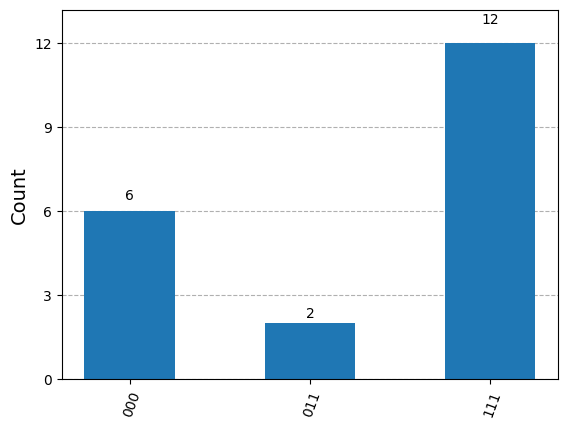

In [26]:
qiskit_result = sweep_job_to_qiskit(job, shots=shots, execution_options=context['options'])
print(f"Qiskit result counts: {qiskit_result.get_counts()}")
visualization.plot_histogram(qiskit_result.get_counts())

We can also submit the same circuit to IQM Server for execution. IQM Server uses a server-side Pulla with fixed standard stages. Since we started with a normal Qiskit backend and a circuit, execution is as simple as:

{'111': 8, '000': 7, '101': 2, '011': 1, '001': 2}


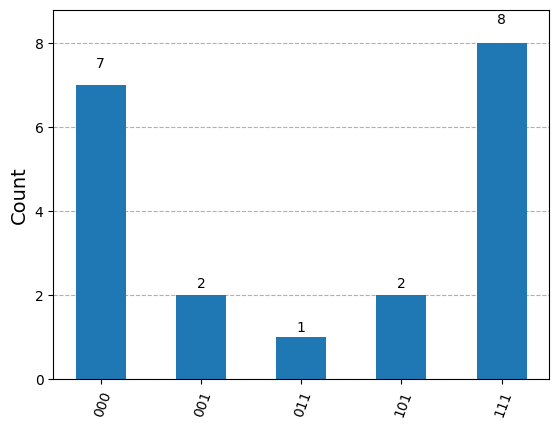

In [27]:
job = backend.run(qc_optimized, shots=shots)

print(job.result().get_counts())
visualization.plot_histogram(job.result().get_counts())